# GEOG5995M Final Assignment: Is Crime Occuring in More Deprived Areas of Manchester?

## Student ID number: 201786174

The Police and Crime Plan 2022–25 of the Greater Manchester Combined Authority highlights the well-established link between crime and deprivation <a href="#ref1">[1]</a>. This strategy emphasises how crucial it is to strengthen communities to lessen public harm and lower crime rates. To provide policymakers, particularly those in the Greater Manchester Combined Authority, with useful information, this analysis aims to explore the complex relationship between deprivation and crime. 

In [339]:
# read in required packages

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# for data manipulation
import pandas as pd
import numpy as np

# for spatial analysis
import geopandas as gpd

# for statistical modelling/ machine learning
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings('ignore')

In [340]:
# reading in datasets needed
crimes = pd.read_csv('2019-06-greater-manchester-street(4).csv')
imd = pd.read_csv('IMD.csv')

The open data for this analysis includes police-recorded crime statistics and the Index for Multiple Deprivation. The Greater Manchester Police recorded crime data covers a year and includes information from all areas of Greater Manchester, however for this analysis, only the city of Manchester is being analysed for a more detailed analysis of a major city <a href="#ref2">[2]</a> . Police-recorded data is predominantly being used as its granularity is the highest available; offences are recorded with a location or often the nearest place where it happened (e.g., On or near Supermarket) which allows the basis of ‘hotspot’ mapping to occur <a href="#ref3">[3]</a>

Small area estimates of relative deprivation at the LSOA level throughout England and Wales are then provided by the Index of Multiple Deprivation  <a href="#ref4">[4]</a>. The location with the most deprivation has the lowest ranking (1), while the place with the least deprivation has the highest rank (9). 

Both sets of data are from 2019, before the Covid-19 pandemic, this was deliberately chosen so more dependable recorded data could be analysed<a href="#ref5">[5]</a>. 

## __Exploring and cleaning police crime data__

In [341]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32058 entries, 0 to 32057
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Crime ID               26427 non-null  object 
 1   Month                  32058 non-null  object 
 2   Reported by            32058 non-null  object 
 3   Falls within           32058 non-null  object 
 4   Longitude              32058 non-null  float64
 5   Latitude               32058 non-null  float64
 6   Location               32058 non-null  object 
 7   LSOA code              32058 non-null  object 
 8   LSOA name              32058 non-null  object 
 9   Crime type             32058 non-null  object 
 10  Last outcome category  26427 non-null  object 
 11  Context                0 non-null      float64
dtypes: float64(3), object(9)
memory usage: 2.9+ MB


In [342]:
# cleaning names 
crimes.columns = crimes.columns.str.lower().str.replace(' ', '_')

In [343]:
# check if its worked 
crimes.info()
# yes!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32058 entries, 0 to 32057
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   crime_id               26427 non-null  object 
 1   month                  32058 non-null  object 
 2   reported_by            32058 non-null  object 
 3   falls_within           32058 non-null  object 
 4   longitude              32058 non-null  float64
 5   latitude               32058 non-null  float64
 6   location               32058 non-null  object 
 7   lsoa_code              32058 non-null  object 
 8   lsoa_name              32058 non-null  object 
 9   crime_type             32058 non-null  object 
 10  last_outcome_category  26427 non-null  object 
 11  context                0 non-null      float64
dtypes: float64(3), object(9)
memory usage: 2.9+ MB


In [344]:
# looking for any missing values
crimes.isna().sum()

crime_id                  5631
month                        0
reported_by                  0
falls_within                 0
longitude                    0
latitude                     0
location                     0
lsoa_code                    0
lsoa_name                    0
crime_type                   0
last_outcome_category     5631
context                  32058
dtype: int64

In [345]:
# dropping 'context' variable as completely empty variable
crimes = crimes.drop(columns =['context'])
crimes.columns

Index(['crime_id', 'month', 'reported_by', 'falls_within', 'longitude',
       'latitude', 'location', 'lsoa_code', 'lsoa_name', 'crime_type',
       'last_outcome_category'],
      dtype='object')

In [346]:
# check to see if any missing long or lat 
crimes['longitude'].isnull().values.any()

False

In [347]:
crimes['latitude'].isnull().values.any()

False

In [348]:
# both false so can call this cleaned? 

A check for missing data in the police-recorded crime dataset was conducted. To streamline the dataset and focus on relevant information, the 'context' variable was identified as non-contributory to the intended analysis and therefore dropped. Furthermore, an important step was to visualise the cleansed crime data before analysing the deprivation statistics. This is so to better understand the nature and distribution of the data to prepare for more informed and targeted analyses. The visualisation below shows crime counts from highest to lowest frequency, with violence and sexual offences being the highest, and bicycle theft being the lowest.

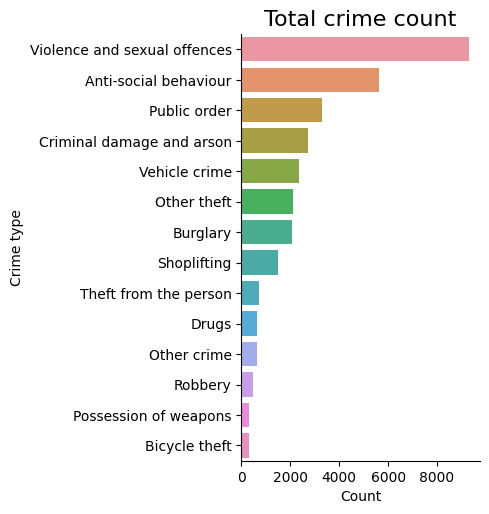

In [349]:
# ordered plot showing highest crime count to least 
sns.catplot(y='crime_type', data=crimes, kind='count', order=crimes['crime_type'].value_counts().index)
#add plot title
plt.title('Total crime count', fontsize=16)

# add axis labels
plt.xlabel('Count')
plt.ylabel('Crime type');

## __Spatial data__

Before examining deprivation, a Manchester wards shapefile from the UK Data Service was imported to visualise this crime data spatially <a href="#ref6">[6]</a>. It was then checked for any missing values and explored before joining with other data to ensure everything was appropriately working.


In [350]:
# bringing in shapefile (manchester from UK data service wards)
boundary = gpd.read_file('england_lsoa_2011.shp')

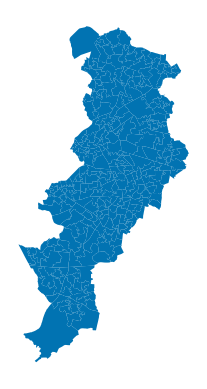

In [351]:
boundary.plot()
plt.axis('off');

In [352]:
# inspecting
boundary.info();

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   label     282 non-null    object  
 1   name      282 non-null    object  
 2   code      282 non-null    object  
 3   geometry  282 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 8.9+ KB


In [353]:
boundary.head()

,label,name,code,geometry
0,E08000003E02006912E01033659,Manchester 055D,E01033659,"POLYGON ((384917.000 398717.000, 384934.000 39..."
1,E08000003E02006916E01033660,Manchester 059B,E01033660,"POLYGON ((382588.604 397521.079, 382702.188 39..."
2,E08000003E02006913E01033665,Manchester 056C,E01033665,"POLYGON ((384484.150 400194.596, 384498.592 40..."
3,E08000003E02001061E01033666,Manchester 017F,E01033666,"POLYGON ((389376.490 397586.794, 389378.188 39..."
4,E08000003E02006902E01033667,Manchester 054E,E01033667,"POLYGON ((384600.530 398906.684, 384608.000 39..."


In [354]:
boundary.isna().sum()

label       0
name        0
code        0
geometry    0
dtype: int64

For spatial mapping, a count of crimes by LSOA in Manchester was made and integrated with the shapefile. This exploratory investigation sheds further light on patterns of localised crime. Again, once this was joined, missing data was checked for and 2 LSOAs with no crime occurrences were replaced with 0s, due to no crime being counted there. The crime count was then rounded to a whole number and made into an integer for a cleaner visualisation, as seen below.

In [355]:
# first creating new object, which has a count of crimes occuring in each lsoa within the crimes dataset
# which can then be used to join to spatial dataset to map

crimes_per_lsoa = crimes.groupby('lsoa_code').size().reset_index(name='count')

print(crimes_per_lsoa)


      lsoa_code  count
0     E01004766     22
1     E01004767     32
2     E01004768      6
3     E01004769      9
4     E01004770      3
...         ...    ...
1666  E01033684      5
1667  E01033685      9
1668  E01033686     20
1669  E01033687     24
1670  E01033688     37

[1671 rows x 2 columns]


In [356]:
crimes_per_lsoa.isna().sum()

lsoa_code    0
count        0
dtype: int64

In [357]:
# doing a left join to merge data
manchester_lsoa = pd.merge(boundary, crimes_per_lsoa, left_on='code', right_on='lsoa_code', how='left')

manchester_lsoa.head()

,label,name,code,geometry,lsoa_code,count
0,E08000003E02006912E01033659,Manchester 055D,E01033659,"POLYGON ((384917.000 398717.000, 384934.000 39...",E01033659,51.0
1,E08000003E02006916E01033660,Manchester 059B,E01033660,"POLYGON ((382588.604 397521.079, 382702.188 39...",E01033660,11.0
2,E08000003E02006913E01033665,Manchester 056C,E01033665,"POLYGON ((384484.150 400194.596, 384498.592 40...",E01033665,62.0
3,E08000003E02001061E01033666,Manchester 017F,E01033666,"POLYGON ((389376.490 397586.794, 389378.188 39...",E01033666,40.0
4,E08000003E02006902E01033667,Manchester 054E,E01033667,"POLYGON ((384600.530 398906.684, 384608.000 39...",E01033667,147.0


In [358]:
# checking for missing data 
manchester_lsoa.isna().sum()

label        0
name         0
code         0
geometry     0
lsoa_code    2
count        2
dtype: int64

In [359]:
# printing the missing data
missing_data = manchester_lsoa[manchester_lsoa['count'].isnull()]
print(missing_data)

                           label             name       code  \
215  E08000003E02001049E01005248  Manchester 005B  E01005248   
244  E08000003E02001079E01005278  Manchester 035D  E01005278   

                                              geometry lsoa_code  count  
215  POLYGON ((388670.207 402311.889, 388670.500 40...       NaN    NaN  
244  POLYGON ((384973.954 393756.428, 384974.041 39...       NaN    NaN  


In [360]:
# replacing the NaN with 0
manchester_lsoa['count'].fillna(0, inplace=True)

In [361]:
# replacing the NaN with 0
manchester_lsoa['lsoa_code'].fillna(0, inplace=True)

In [362]:
# checking to see if it has worked
manchester_lsoa.isna().sum()

label        0
name         0
code         0
geometry     0
lsoa_code    0
count        0
dtype: int64

In [363]:
# then need to round count to a whole number and make it into an integer
manchester_lsoa['count'] = manchester_lsoa['count'].round(0).astype(int)

In [364]:
manchester_lsoa.head()

,label,name,code,geometry,lsoa_code,count
0,E08000003E02006912E01033659,Manchester 055D,E01033659,"POLYGON ((384917.000 398717.000, 384934.000 39...",E01033659,51
1,E08000003E02006916E01033660,Manchester 059B,E01033660,"POLYGON ((382588.604 397521.079, 382702.188 39...",E01033660,11
2,E08000003E02006913E01033665,Manchester 056C,E01033665,"POLYGON ((384484.150 400194.596, 384498.592 40...",E01033665,62
3,E08000003E02001061E01033666,Manchester 017F,E01033666,"POLYGON ((389376.490 397586.794, 389378.188 39...",E01033666,40
4,E08000003E02006902E01033667,Manchester 054E,E01033667,"POLYGON ((384600.530 398906.684, 384608.000 39...",E01033667,147


Four choropleth maps—each with a unique classification—were then made to highlight the spatial distribution of crime across Manchester. Fisher-Jenks arguably is the most appropriate classification to visualise for this analysis, as the crime distribution classifies according to the inherent groupings found in the existing data <a href="#ref7">[7]</a>. This classification method has also been used in the literature to show variations in the spatial distribution of criminal incidents, specifically for crime data <a href="#ref8">[8]</a>.

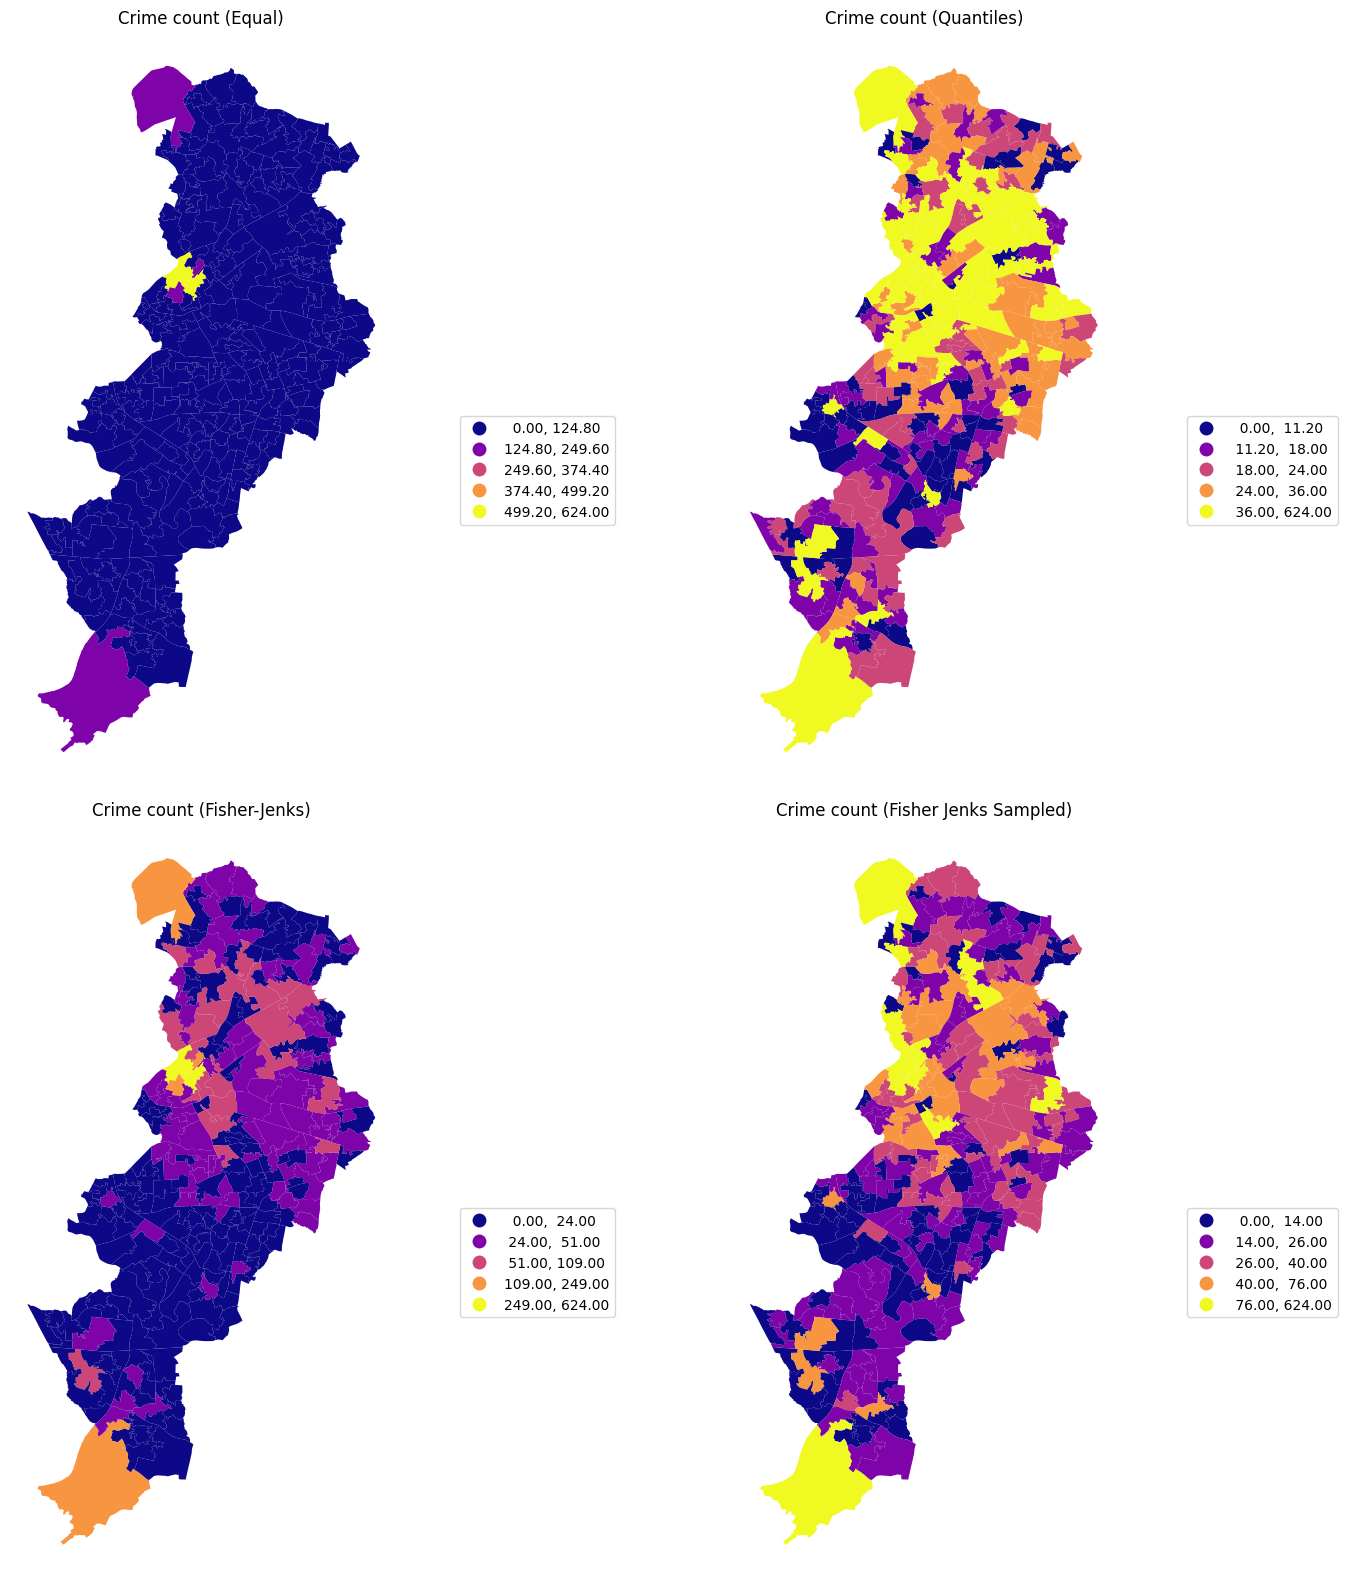

In [365]:
# spatially visualising crime count, looking at different chloropleths 
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Equal map
ax1 = axes[0, 0]
manchester_lsoa.plot(column='count', categorical=True, legend=True, cmap='plasma', scheme='equal_interval', ax=ax1)
ax1.set_axis_off()
legend1 = ax1.get_legend()
if legend1:
    legend1.set_bbox_to_anchor((1.60, 0.5))
ax1.set_title('Crime count (Equal)')

# Quantiles map
ax2 = axes[0, 1]
manchester_lsoa.plot(column='count', categorical=True, legend=True, cmap='plasma', scheme='quantiles', ax=ax2)
ax2.set_axis_off()
legend2 = ax2.get_legend()
if legend2:
    legend2.set_bbox_to_anchor((1.60, 0.5))
ax2.set_title('Crime count (Quantiles)')

# Fisher-jenks
ax3 = axes[1, 0]
manchester_lsoa.plot(column='count', categorical=True, legend=True, cmap='plasma', scheme='fisher_jenks', ax=ax3)
ax3.set_axis_off()
legend3 = ax3.get_legend()
if legend3:
    legend3.set_bbox_to_anchor((1.60, 0.5))
ax3.set_title('Crime count (Fisher-Jenks)')

# Fisher-jenks sampled
ax4 = axes[1, 1]
manchester_lsoa.plot(column='count', categorical=True, legend=True, cmap='plasma', scheme='fisher_jenks_sampled', ax=ax4)
ax4.set_axis_off()
legend4 = ax4.get_legend()
if legend4:
    legend4.set_bbox_to_anchor((1.60, 0.5))
ax4.set_title('Crime count (Fisher Jenks Sampled)')

plt.tight_layout()

plt.show();


## __Deprivation Data__

The deprivation data, measuring relative deprivation at the LSOA level, was then introduced to assess the correlation between crime and deprivation in Manchester. The same cleaning process previously applied to the crime data and shapefile was employed for consistency.

In [366]:
imd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 6 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   LSOA code (2011)                            32844 non-null  object
 1   LSOA name (2011)                            32844 non-null  object
 2   Local Authority District code (2019)        32844 non-null  object
 3   Local Authority District name (2019)        32844 non-null  object
 4   Index of Multiple Deprivation (IMD) Rank    32844 non-null  object
 5   Index of Multiple Deprivation (IMD) Decile  32844 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [367]:
# cleaning names 
imd.columns = imd.columns.str.lower().str.replace(' ', '_')

In [368]:
# check if its worked 
imd.info()
# yes!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 6 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   lsoa_code_(2011)                            32844 non-null  object
 1   lsoa_name_(2011)                            32844 non-null  object
 2   local_authority_district_code_(2019)        32844 non-null  object
 3   local_authority_district_name_(2019)        32844 non-null  object
 4   index_of_multiple_deprivation_(imd)_rank    32844 non-null  object
 5   index_of_multiple_deprivation_(imd)_decile  32844 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [369]:
# looking for any missing values
imd.isna().sum()
#there are no missing values 

lsoa_code_(2011)                              0
lsoa_name_(2011)                              0
local_authority_district_code_(2019)          0
local_authority_district_name_(2019)          0
index_of_multiple_deprivation_(imd)_rank      0
index_of_multiple_deprivation_(imd)_decile    0
dtype: int64

In [370]:
imd.head()

,lsoa_code_(2011),lsoa_name_(2011),local_authority_district_code_(2019),local_authority_district_name_(2019),index_of_multiple_deprivation_(imd)_rank,index_of_multiple_deprivation_(imd)_decile
0,E01000001,City of London 001A,E09000001,City of London,"29,199",9
1,E01000002,City of London 001B,E09000001,City of London,"30,379",10
2,E01000003,City of London 001C,E09000001,City of London,"14,915",5
3,E01000005,City of London 001E,E09000001,City of London,"8,678",3
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,"14,486",5


Our concentration is on Manchester, but the deprivation data initially covers LSOAs outside of this area. A cleaner dataset was obtained by extracting only the LSOA code and decile. After that, this was combined with the already-existing Manchester LSOA data by matching the appropriate LSOA codes with each other. This was done to provide a single dataset that could be used for analysis and decile rank mapping.

In [371]:
# creating new object, which has only the decile and lsoa code 
# which can then be used to join with existing crime spatial data

dep_per_lsoa = pd.DataFrame({
    'lsoa_code': imd['lsoa_code_(2011)'],
    'decile': imd['index_of_multiple_deprivation_(imd)_decile']
})

In [372]:
dep_per_lsoa.head()

,lsoa_code,decile
0,E01000001,9
1,E01000002,10
2,E01000003,5
3,E01000005,3
4,E01000006,5


In [373]:
# checking for missing data again now its been added to lsoa data
dep_per_lsoa.isna().sum()

lsoa_code    0
decile       0
dtype: int64

## __Final Dataset and Analysis__

In [374]:
# Putting it all together !
merged_df = manchester_lsoa.merge(dep_per_lsoa, on='lsoa_code', how='left')

In [375]:
merged_df.head()

,label,name,code,geometry,lsoa_code,count,decile
0,E08000003E02006912E01033659,Manchester 055D,E01033659,"POLYGON ((384917.000 398717.000, 384934.000 39...",E01033659,51,4.0
1,E08000003E02006916E01033660,Manchester 059B,E01033660,"POLYGON ((382588.604 397521.079, 382702.188 39...",E01033660,11,5.0
2,E08000003E02006913E01033665,Manchester 056C,E01033665,"POLYGON ((384484.150 400194.596, 384498.592 40...",E01033665,62,2.0
3,E08000003E02001061E01033666,Manchester 017F,E01033666,"POLYGON ((389376.490 397586.794, 389378.188 39...",E01033666,40,1.0
4,E08000003E02006902E01033667,Manchester 054E,E01033667,"POLYGON ((384600.530 398906.684, 384608.000 39...",E01033667,147,2.0


In [376]:
merged_df.tail()

,label,name,code,geometry,lsoa_code,count,decile
277,E08000003E02001097E01005314,Manchester 053B,E01005314,"POLYGON ((382328.294 386558.294, 382329.242 38...",E01005314,6,1.0
278,E08000003E02001097E01005315,Manchester 053C,E01005315,"POLYGON ((382318.500 386633.261, 382307.895 38...",E01005315,12,1.0
279,E08000003E02001097E01005316,Manchester 053D,E01005316,"POLYGON ((381869.176 386765.737, 381869.567 38...",E01005316,155,3.0
280,E08000003E02001096E01005317,Manchester 052E,E01005317,"POLYGON ((383177.594 386571.094, 383201.094 38...",E01005317,22,1.0
281,E08000003E02001095E01005319,Manchester 051E,E01005319,"POLYGON ((381789.467 387174.190, 381798.483 38...",E01005319,26,1.0


It was then found that there appeared to be two missing decile counts within the newly merged data, this appeared to be the same LSOAs that also had no crime counted in these locations. However, rather than just removing these LSOAs from analysis and creating an empty LSOA on the graph, an external source was used to find the recorded deprivation decile from 2019 – this was then recoded to reflect that, and then mapped to check it was no longer missing <a href="#ref9">[9]</a>.

In [377]:
# checking for missing data 
merged_df.isna().sum()

label        0
name         0
code         0
geometry     0
lsoa_code    0
count        0
decile       2
dtype: int64

In [378]:
# printing missing data
missing_data = merged_df[merged_df['decile'].isnull()]
print(missing_data)

                           label             name       code  \
215  E08000003E02001049E01005248  Manchester 005B  E01005248   
244  E08000003E02001079E01005278  Manchester 035D  E01005278   

                                              geometry lsoa_code  count  \
215  POLYGON ((388670.207 402311.889, 388670.500 40...         0      0   
244  POLYGON ((384973.954 393756.428, 384974.041 39...         0      0   

     decile  
215     NaN  
244     NaN  


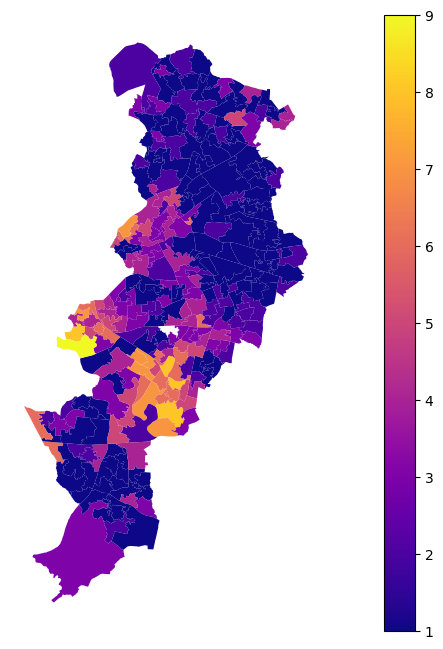

In [379]:
# visualising the missing data
f,ax = plt.subplots(1, figsize=(16,8))
merged_df.plot(column='decile',legend=True, cmap="plasma", ax=ax)
# remove axis
ax.set_axis_off()
plt.show();

In [380]:
# replacing the missing decile with its actual deprivation decile from 2019
merged_df['decile'].fillna(-1, inplace=True)

lsoa_code = 'E01005248' # old moat
lsoa_code2 = 'E01005278' # charlestown


merged_df.loc[merged_df['code'] == lsoa_code, 'decile'] = 3
merged_df.loc[merged_df['code'] == lsoa_code2, 'decile'] = 2

In [381]:
merged_df.isna().sum()

label        0
name         0
code         0
geometry     0
lsoa_code    0
count        0
decile       0
dtype: int64

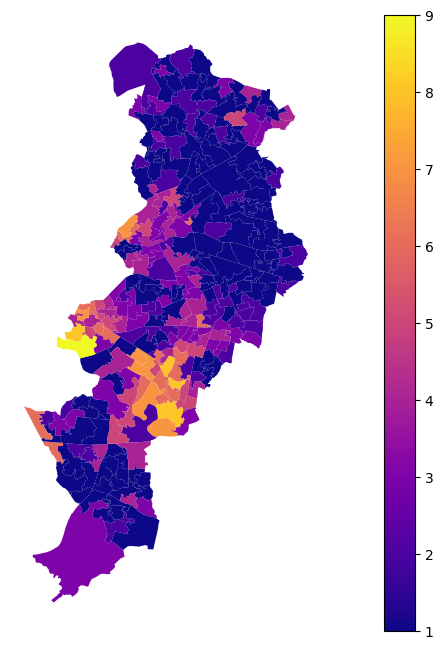

In [382]:
# plotting to see if it worked
f,ax = plt.subplots(1, figsize=(16,8))
merged_df.plot(column='decile',legend=True, cmap="plasma", ax=ax)
# remove axis
ax.set_axis_off()
plt.show();

## __Regression__

A generalised linear regression model was employed to investigate the relationship between crime counts and deprivation decile values. This regression method is suitable for analysing count data and is commonly used in addressing issues related to crime rates <a href="#ref10">[10]</a>.
     Before the analysis, the variable's correlation was examined to understand if there was a relationship present. With only two variables, the correlation was easily discernible. The distribution of crime counts visualised afterwards, exhibited a skewed distribution, as expected due to a significant number of zero crime occurrences. These zero counts were however retained, as they are crucial for understanding whether crime is more prevalent in deprived areas or not.


In [383]:
# regression to see if deprivation can predict crime 
merged_df.select_dtypes(include=np.number).corr()

,count,decile
count,1.000000,-0.046028
decile,-0.046028,1.000000


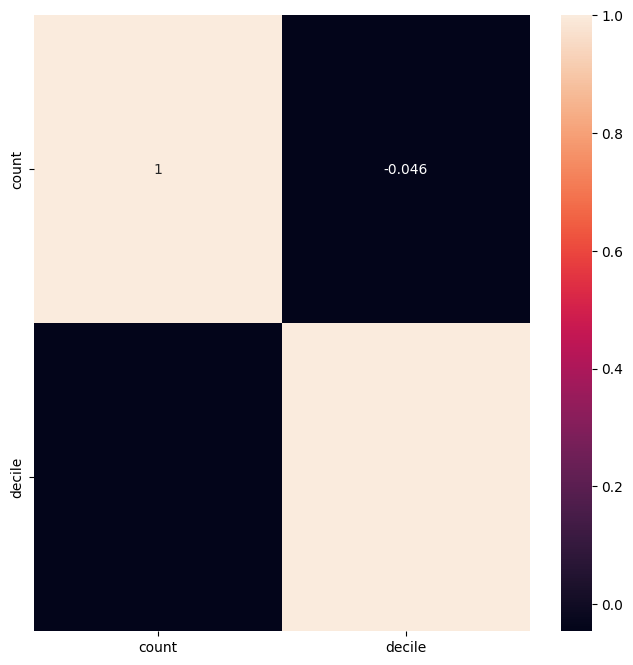

In [384]:
plt.figure(figsize=(8,8))
# plot heatmap
sns.heatmap(merged_df.select_dtypes(include=np.number).corr(), annot=True);

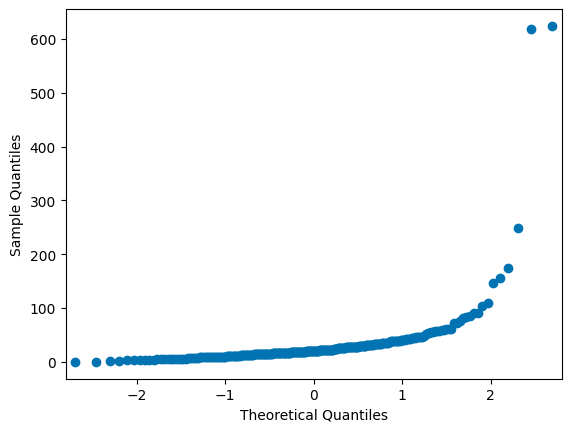

In [385]:
# plot a qqplot to see if t1 is normally distributed 
sm.qqplot(merged_df['count']);

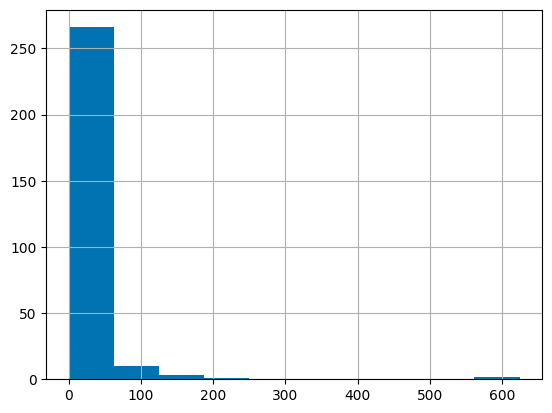

In [386]:
# plot a histogram for the same as above
merged_df['count'].hist();

The regression results below revealed a negative association between higher deprivation decile values and expected crime counts. It is essential to note here that a higher deprivation decile signifies lower deprivation (9 being the least deprived in the Index of Multiple Deprivation Scale). A one-unit increase in deprivation is associated with a 4.75 expected decrease in crime counts, with other variables held constant. This finding aligns with visual observations, where areas of greater deprivation tended to have higher crime counts. The very low p-value (0.000) also attests to the statistical significance of the coefficient, indicating a robust relationship between crime count and deprivation decile in the model.

In [387]:
# To predict count we need to use a poisson generalsied linear model as it is a count outcome.

# Define the model equation
model2 = smf.glm(formula = "count ~ decile",\
                #specify data source
                data=merged_df,\
                # specify poisson transformation
                family=sm.families.Poisson()).fit()

# Print out the summary statistics of the model
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  count   No. Observations:                  282
Model:                            GLM   Df Residuals:                      280
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5589.4
Date:                Wed, 06 Dec 2023   Deviance:                       9807.3
Time:                        16:45:17   Pearson chi2:                 2.98e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1987
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5604      0.018    197.307      0.000       3.525       3.596
decile        -0.0475      0.006     -7.763      0.000      -0.059      -0.035
==============================================================================
"""

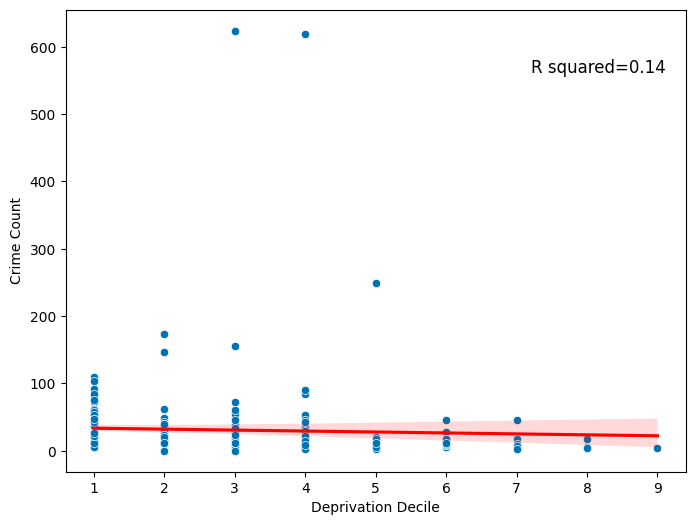

In [388]:
# plotting regression results

# define r squared
# model.rsquared: return the R^2 value
# round( ,2): rounds R^2 to 2 decimal places
r2 = round(model.rsquared, 2)

# define figure size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed

# plot scatter plot
sns.scatterplot(data=merged_df, x='decile', y='count');

# plot regression line with a red color
sns.regplot(data=merged_df, x='decile', y='count', scatter=False, color='red');

# add text labels and format
text_position_x = merged_df['decile'].max() * 0.8  # Adjust the x-axis position
text_position_y = merged_df['count'].max() * 0.9  # Adjust the y-axis position
ax.text(text_position_x, text_position_y, "R squared=" + str(r2), fontsize=12)
ax.set_xlabel('Deprivation Decile')
ax.set_ylabel('Crime Count');

plt.show();



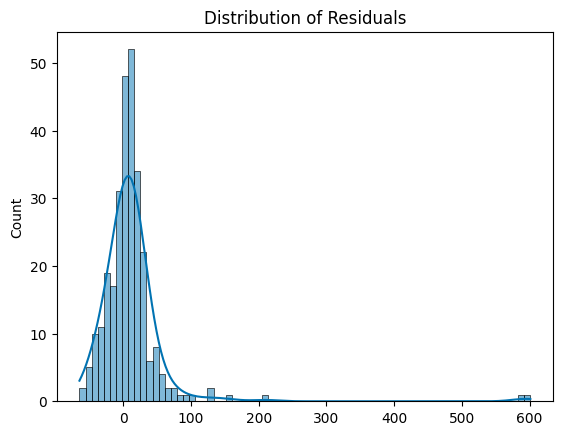

In [389]:
# plot the residuals
residuals = model.resid

# Check normality of residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show();

## __Data Visualisation__


In designing the first non-spatial data visualisation for policymakers seen below, several deliberate choices were made to optimise clarity and relevance. The creation of a grouped dataset focused on crime types allowed for a more targeted exploration. By aggregating crime counts based on both deprivation decile and crime type, the visual representation highlighed the most prevalent criminal activities. The selection of a colourblind-friendly palette not only ensured accessibility but also added visual interest<a href="#ref11">[11]</a>. The decision to use a stacked bar plot effectively conveyed the distribution of different crime types within each decile. Customisations such as axis labels, title, and legend placement were incorporated to enhance overall comprehension. The removal of unnecessary spines contributed to a cleaner aesthetic, while adjustments to spacing and layout were made for improved readability. Additionally, the inclusion of custom labels for specific deciles provided additional context. These choices collectively aimed to present a comprehensive yet focused data visualisation that is accessible, visually appealing, and directly aligned with the needs of policymakers through a simple yet effective graph.

<Figure size 1800x1200 with 0 Axes>

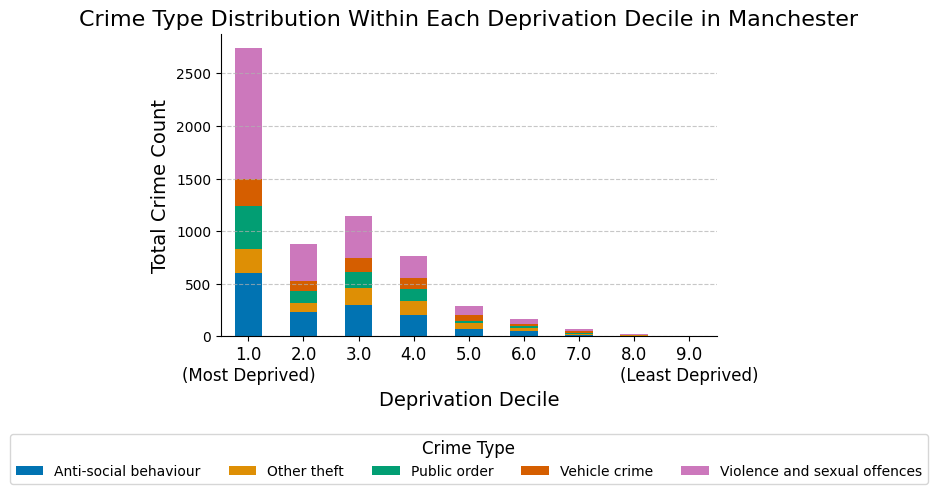

In [390]:
# non-spatial visualisation

# wanting to show crime types so a new grouped dataset is needed
crime_type_decile = pd.merge(crimes, merged_df[['lsoa_code', 'decile']], on='lsoa_code', how='left')

# aggregate crime counts by decile and crime type
agg_df = crime_type_decile.groupby(['decile', 'crime_type']).size().reset_index(name='count')

# limit to the top 5 crimes (online)
top_n = 5
top_crime_types = agg_df.groupby('crime_type')['count'].sum().nlargest(top_n).index
filtered_df = agg_df[agg_df['crime_type'].isin(top_crime_types)]

# pivot the DataFrame to have crime types as separate columns (online)
pivot_df = filtered_df.pivot(index='decile', columns='crime_type', values='count')

# set a color palette 
sns.set_palette("colorblind", n_colors=top_n)

# making a stacked bar plot showing the distribution of different crime types within each decile
plt.figure(figsize=(18, 12))
ax = pivot_df.plot(kind='bar', stacked=True, rot=0)

# customise the plot
plt.xlabel('Deprivation Decile', fontsize=14)
plt.ylabel('Total Crime Count', fontsize=14)
plt.title('Crime Type Distribution Within Each Deprivation Decile in Manchester', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12, rotation=0, ha='center')  # Straighten x-axis labels

# add custom labels for 1 (most deprived) and 9 (least deprived)
xtick_labels = [f'{i}\n{"(Most Deprived)" if i == 1 else "(Least Deprived)" if i == 9 else ""}' for i in pivot_df.index]
plt.xticks(range(len(pivot_df.index)), xtick_labels)

# remove top and right spines for cleaner aesthetics
sns.despine()

# move the legend to the bottom without a box
ax.legend(title='Crime Type', title_fontsize='12', fontsize='10', bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=len(top_crime_types))

# adjust layout to add some space between subplots
plt.subplots_adjust(bottom=0.25)

# show the plot
plt.show();

In the second spatial visualisation seen below, considerable care was taken to ensure that the visualisation effectively communicated its findings to policymakers. The visualisation is divided into two subplots: the first shows crime counts (categorised for clarity using Fisher-Jenks classification), and the second shows deprivation levels. The colour palette 'Viridis' was selected based on its colour-blind accessibility, and the title communicates the idea of contrasting crime rates with deprivation in Manchester's LSOAs. The axes were purposefully hidden to keep the design neat and uncomplicated. For the crime count map, a unique colour bar that matched the deprivation map's legend style was also made <a href="#ref12">[12]</a>. Furthermore, the legend colours for the deprivation map were reversed, the colours on both maps represented the same thing: high crime and high deprivation or likewise. A visually striking and educational map was intended this visualisation to help policymakers better communicate the intricate relationship between deprivation and crime in Manchester.

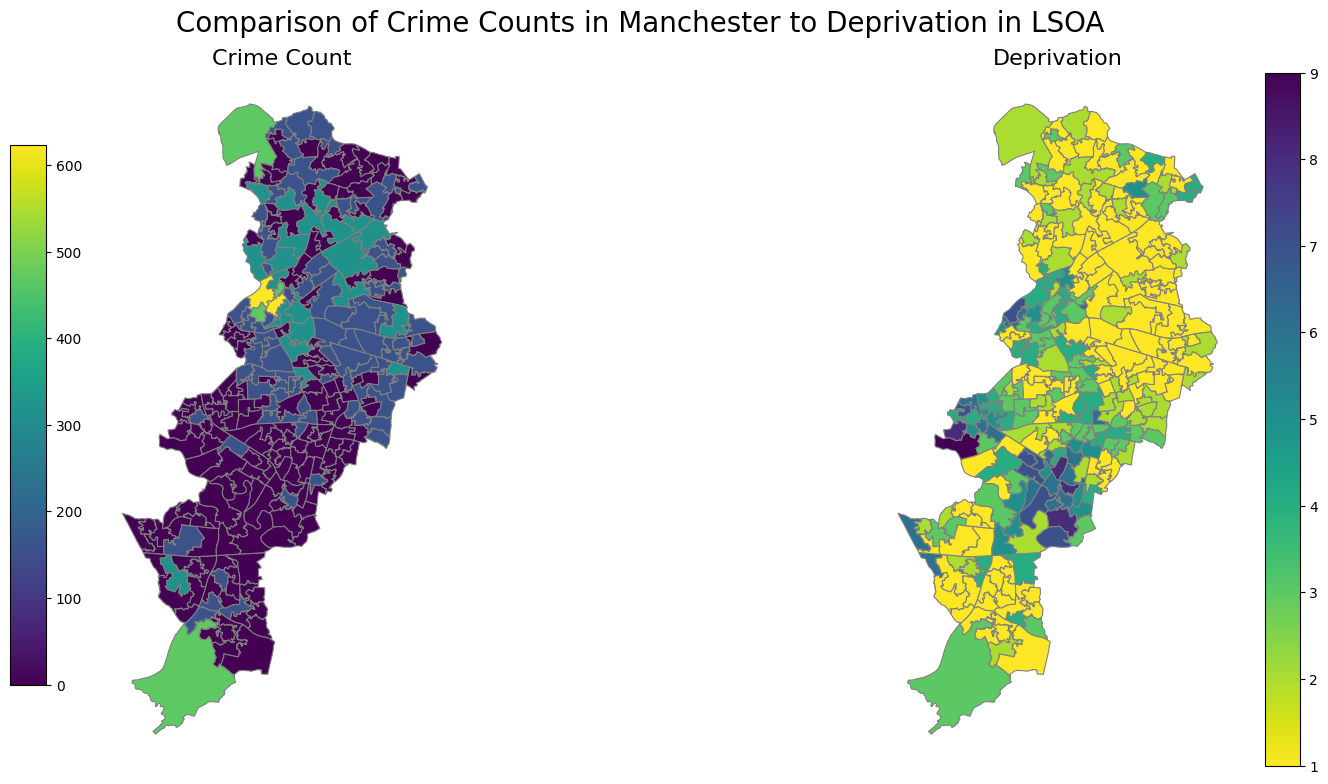

In [391]:
# Spatial visualisation 

# create a figure with two subplots (maps)
f, ax = plt.subplots(1, 2, figsize=(18, 9))

# plot crime count map with Fisher-Jenks classification in subplot 1
crime_count_plot = merged_df.plot(ax=ax[0], column='count', cmap='viridis', scheme='fisher_jenks', linewidth=0.8, edgecolor='grey', legend=False)

# plot deprivation map 
dep_map = merged_df.plot(ax=ax[1], column='decile', cmap='viridis_r', linewidth=0.8, edgecolor='grey', legend=True)

# set titles
ax[0].set_title('Crime Count', fontsize=16)
ax[1].set_title('Deprivation', fontsize=16)

# add an overall title
plt.suptitle('Comparison of Crime Counts in Manchester to Deprivation in LSOA', fontsize=20, y=0.95)

# make axes invisible
ax[0].set_axis_off()
ax[1].set_axis_off()

# create a custom colorbar for crime count map to mimic the legend style of the decile map (CHAT GPT used for creating this)
cax = f.add_axes([0.15, 0.2, 0.02, 0.6])  # Adjust the position and size as needed
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=merged_df['count'].min(), vmax=merged_df['count'].max()))
sm._A = []  # Fake the scalar mappable array
cbar = plt.colorbar(sm, cax=cax, format='%d')  # Use '%d' for integer formatting

# show the figure
plt.show();

The two visual aids efficiently highlight the conclusions drawn from the generalised linear regression model and the data analysis, confirming a relationship between increased crime rates and higher levels of deprivation in Manchester. The map accurately shows the regions where this association is strongest, giving policymakers precise places to put targeted initiatives into place, effectively breaking the negative relationship between deprivation and crime. In addition, each decile's most common offences are presented in detail via the graphic visualisation, which provides information that can help determine which interventions should be prioritised. For instance, there are important policy and public welfare consequences for the prevalence of sexual offences and violence in the poorest neighbourhoods. This is consistent with current policy insights that show a substantial inequality gradient, especially when it comes to violent crimes <a href="#ref9">[9]</a>. The visual representation not only reinforces this gradient but also serves as compelling evidence supporting strategic initiatives, such as those outlined in the Greater Manchester Serious Violence Action Plan. Implementing community support in high-need areas or establishing a dedicated Violence Reduction Unit is not only advantageous for deprived communities but also contributes significantly to fostering safer environments for the broader public. Furthermore, the correlation between these crimes and deprivation is further emphasized by identifying primary offences in Manchester's most impoverished regions. These insights collectively emphasize the urgency and importance of holistic policies that extend beyond law enforcement, addressing the root causes of deprivation to effectively mitigate crime and enhance public safety.

## References
<p><a href="https://www.greatermanchester-ca.gov.uk/what-we-do/police-and-fire/police-and-crime-plan/">[1]</a>Authority, G.M.C. (2022) Police and Crime Plan, Greater Manchester Combined Authority. (Accessed: 1 December 2023).
</p>
<p><a href="https://data.police.uk/data/statistical-data/">[2]</a>Data.Police.UK (2023). Statistical data. (Accessed 28 Novemver 2023).</p>
<p><a href="https://doi.org/10.1017/S1472669616000207.">[3]</a>Brimicombe, A. (2016). ‘Analysing Police-Recorded Data’, Legal Information Management, 16(2), pp. 71–77.</p>
<p><a href="https://data.cdrc.ac.uk/dataset/index-multiple-deprivation-imd">[4]</a>CDRC (2023). Index of Multiple Deprivation. (Accessed 28 November 2023).</p>
<p><a href="https://blog.ons.gov.uk/2021/11/04/understanding-the-impact-of-the- pandemic-on-levels-of-crime-in-england-and-wales/">[5]</a>Office for National Statistics (2021). Understanding the impact of the pandemic on levels of crime in England and Wales. Available at:  (Accessed 2 December 2023).</p>
<p><a href="https://borders.ukdataservice.ac.uk/bds.html">[6]</a>UK Data Service. Census Support. (Accessed 28 November 2023)</p>
<p><a href="https://www.taylorfrancis.com/books/mono/10.1201/9781003150527/thematic-cartography-geovisualization-fourth-edition-terry-slocum-robert-mcmaster-fritz-kessler-hugh-howard">[7]</a>Slocum, T.A. et al. (2008) Thematic Cartography and Geographic Visualization. Upper Saddle River, New Jersey: Prentice Hall.</p>
<p><a href="https://doi.org/10.1504/IJBDI.2020.106177">[8]</a>Bani-Taha, O.I. and Shafiq, M.O. (2020) ‘Combining the richness of GIS techniques with visualisation tools to better understand the spatial distribution of data - a case study of Chicago City crime analysis’, International Journal of Big Data Intelligence, 7(1), pp. 29–46.</p>
<p><a href="https://www.trafforddatalab.io/deprivation.html">[9]</a>Trafford Data Lab. Indices of Deprivation 2019. Accessed 2 December 2019</p>
<p><a href="https://www.taylorfrancis.com/chapters/edit/10.4324/9781315089256-23/poisson-based-regression-analysis-aggregate-crime-rates-wayne-osgood">[10]</a>Osgood, D.W. (2005) ‘Poisson-Based Regression Analysis of Aggregate Crime Rates’, in Quantitative Methods in Criminology. Routledge.</p>
<p><a href="https://doi.org/10.13140/RG.2.2.24103.27043">[11]</a>Ravilious, C. et al. (2020) How to Present Complex Data on Maps and other Visuals for Effective Policy Communication: Using visual tools and spatial information to support decisions for REDD+ implementation. (Accessed 5 December 2023)</p>
<p><a href="https://chat.openai.com/">[12]</a>Chat GPT</p>
<p><a href="https://github.com/FrancescaPontin/GEOG5995">[13]</a>GEOG5995M course materials</p>

